# View Calspec Observed flux in AuxTel

- Author : Sylvie Dagoret-Campagne
- Creation : 27 september 2019
- Update : April 20th 2020 for package PhotomCorrectAuxTel (not using libradtran)

Here we don't run atmospheric simulation with libradtran, but use already done simulation

In [45]:
import os,sys
import numpy as np

In [46]:
from astropy.table import Table
from astropy.io import fits

In [47]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [48]:
import pysynphot as S

In [49]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')

In [50]:
import scipy.special as sp

In [51]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(14,8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

# Initialisation

## Simulation of atmosphere

In [52]:
FLAG_LIBRADTRAN=False

In [53]:
if FLAG_LIBRADTRAN:
    PATH_ATMTRANSPSIM='../libradtransim'
    sys.path.append(PATH_ATMTRANSPSIM)
else:
    PATH_ATMDATADIR="../../data/atm"
    sys.path.append(PATH_ATMDATADIR)

## Simulation Quantum Efficiency

In [54]:
PATH_LSSTFiltersKG='../../data/lsst/LSSTFiltersKG'
sys.path.append(PATH_LSSTFiltersKG)
PATH_LSSTFiltersKGDATA='../../data/lsst/LSSTFiltersKG/fdata'
sys.path.append(PATH_LSSTFiltersKGDATA)

## Import

In [55]:
import libLSSTFiltersKG as lsst

In [56]:
if FLAG_LIBRADTRAN:
    import libsimulateTranspLSSTScattAbsAer3 as atm

# Read the required data

## Read the CALSPEC Table

In [57]:
t=Table.read('table_summary_calspec_hd.fits')

In [58]:
print(t)

OBJNAME          RA         ...        magV                FILES         
-------- ------------------ ... ------------------ ----------------------
HD009051 22.193760833333332 ...  8.920000076293945 hd009051_stis_003.fits
HD031128  73.04129041666667 ...  9.140000343322754 hd031128_stis_003.fits
HD074000        130.2116825 ...   9.65999984741211 hd074000_stis_003.fits
HD106252 183.37295833333332 ...              1e+20 hd106252_stis_004.fits
HD111980 193.31271999999998 ...  8.380000114440918 hd111980_stis_003.fits
HD116405 200.68801541666664 ...   8.34000015258789 hd116405_stis_004.fits
 HD14943  35.72781333333333 ... 5.8979997634887695  hd14943_stis_004.fits
HD158485 261.52015416666666 ...   6.49399995803833 hd158485_stis_004.fits
HD159222 263.00413416666663 ...              1e+20 hd159222_stis_004.fits
HD160617  265.7055145833333 ...  8.729999542236328 hd160617_stis_003.fits
HD163466 268.10573166666666 ...  6.849999904632568 hd163466_stis_004.fits
HD180609  288.1966645833333 ...  9.420

In [59]:
NBFILES=len(t)

## Add visibility flag

In [60]:
FLAG_VISIBILITY= [True] * NBFILES

In [61]:
t_vis=t

In [62]:
t_vis["vis"]=FLAG_VISIBILITY

In [63]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES), alpha=1)

## Read all spectra

In [64]:
all_sed=[]
all_label=[]
idx=0
for filename in t_vis["FILES"]:
    
    fullfilename=os.path.join(path_sed_calspec,filename)
    spec=S.FileSpectrum(fullfilename)
    
    spec.convert('photlam')
    spec.convert('nm') 
    label=t_vis["OBJNAME"][idx]+" ( "+t_vis["SP_TYPE"][idx]+" )"
       
    all_sed.append(spec)
    all_label.append(label)
        
    idx+=1

Warning, 9 of 3739 bins contained negative fluxes; they have been set to zero.
Warning, 19 of 6265 bins contained negative fluxes; they have been set to zero.
Warning, 22 of 7206 bins contained negative fluxes; they have been set to zero.
Warning, 3 of 7208 bins contained negative fluxes; they have been set to zero.
Warning, 12 of 6264 bins contained negative fluxes; they have been set to zero.
Warning, 44 of 7210 bins contained negative fluxes; they have been set to zero.
Warning, 53 of 7209 bins contained negative fluxes; they have been set to zero.
Warning, 16 of 3740 bins contained negative fluxes; they have been set to zero.
Warning, 6 of 6264 bins contained negative fluxes; they have been set to zero.
Warning, 27 of 7207 bins contained negative fluxes; they have been set to zero.
Warning, 13 of 6263 bins contained negative fluxes; they have been set to zero.
Warning, 1 of 6265 bins contained negative fluxes; they have been set to zero.


## Get Atmosphere

In [65]:
if FLAG_LIBRADTRAN:
    am=1.
    pwv=2.
    ozone=0.
    lambda0_aerosol=500.
    tau_aerosol=0.
    
    ##### --- call to libradtran
    # OLD : path,thefile=atm.ProcessSimulationaer(am,pwv,ozone,lambda0_aerosol,tau_aerosol)
    # NEW def ProcessSimulationaer(airmass_num, pwv_num, oz_num, aer_num, press_num, prof_str='us', proc_str='sa')

    path, thefile = atm.ProcessSimulationaer(am, pwv, ozone,tau_aerosol,0)

    fullfilename=os.path.join(path,thefile)
    atm_data=np.loadtxt(fullfilename)
    wl_atm=atm_data[:,0]
    tr_atm=atm_data[:,1] 

In [66]:
if FLAG_LIBRADTRAN:
    am=1.
    pwv=10.
    ozone=600.
    lambda0_aerosol=500.
    tau_aerosol=0.15
    
    ##### --- call to libradtran
    # OLD : path,thefile=atm.ProcessSimulationaer(am,pwv,ozone,lambda0_aerosol,tau_aerosol)
    # NEW def ProcessSimulationaer(airmass_num, pwv_num, oz_num, aer_num, press_num, prof_str='us', proc_str='sa')

    path, thefile = atm.ProcessSimulationaer(am, pwv, ozone,tau_aerosol,0)

    fullfilename=os.path.join(path,thefile)
    atm_data=np.loadtxt(fullfilename)
    wl_atm2=atm_data[:,0]
    tr_atm2=atm_data[:,1] 

In [67]:
if not FLAG_LIBRADTRAN:
    """
    Read all fits files, extract images, glue images alltogether and find the best and worse atmosphere
    """
    atmospheric_basename_files=os.listdir(PATH_ATMDATADIR)
    
    idx=0
    all_data=[]
    all_hdr=[]
    all_wl=[]
    for file in atmospheric_basename_files:
        inputfile=os.path.join(PATH_ATMDATADIR,file)
        hdu = fits.open(inputfile)
        all_hdr.append(hdu[0].header)
        all_data.append(hdu[0].data[1:,:])
        all_wl.append(hdu[0].data[0,:])
        idx+=1
        hdu.close()
        
    data=np.vstack(all_data)
    hdr=all_hdr[0]
    
    
    NbAtmSimul=hdr['NBATMSIM']
    idx_out_num=hdr['ID_NUM']
    idx_out_year=hdr['ID_YEAR']
    idx_out_am=hdr['ID_AM']
    idx_out_vaod=hdr['ID_VAOD']
    idx_out_pwv=hdr['ID_PWV']
    idx_out_o3=hdr['ID_O3']
    idx_out_cld=hdr['ID_CLD']
    idx_out_res=hdr['ID_RES']
    
    vaod=data[1:,idx_out_vaod] # vertical aerosol depth
    pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
    o3=data[1:,idx_out_o3]     # ozone
    cld=data[1:,idx_out_cld]   # clouds (not used)
    
    wl_atm=all_wl[0][idx_out_res:]
    transm=data[:,idx_out_res:]
    

    NBSIM=transm.shape[0]
    
    transmsum=np.zeros(NBSIM)
    for idx in np.arange(NBSIM):
        transmsum[idx]=transm[idx,:].sum()
        
    idx_best_atm=np.where(transmsum==transmsum.min())[0][0]
    idx_worse_atm=np.where(transmsum==transmsum.max())[0][0]
    
    tr_atm=transm[idx_best_atm,:]
    tr_atm2=transm[idx_worse_atm,:]

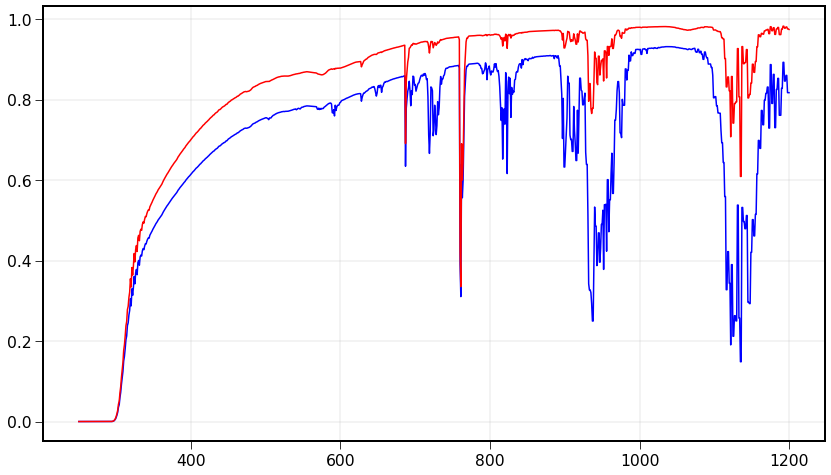

In [68]:
plt.plot(wl_atm,tr_atm,'b-')
plt.plot(wl_atm,tr_atm2,'r-')

plt.grid()

In [69]:
bp_atm= S.ArrayBandpass(wl_atm*10.,tr_atm, name="atm")

## Get Quantum Efficiency

In [70]:
!ls $PATH_LSSTFiltersKGDATA

LSST-G.xls                LSST-Y4.kg.xls            ideal_r.txt
LSST-I (version 1).xls    LSST-Y4_kg.xls            ideal_u.txt
LSST-I.xls                LSST-Z (version 1).xls    ideal_y4.txt
LSST-R.xls                LSST-Z.xls                ideal_z.txt
LSST-ThroughputCCD.xlsx   MirrorsThroughput.xlsx    lsst_mirrorthroughput.txt
LSST-U (version 1).xls    ideal_g.txt
LSST-U.xls                ideal_i.txt


In [71]:
wl,throughput,ccdqe,trans_opt_elec=lsst.GetThroughputAndCCDQE("../../data/lsst")

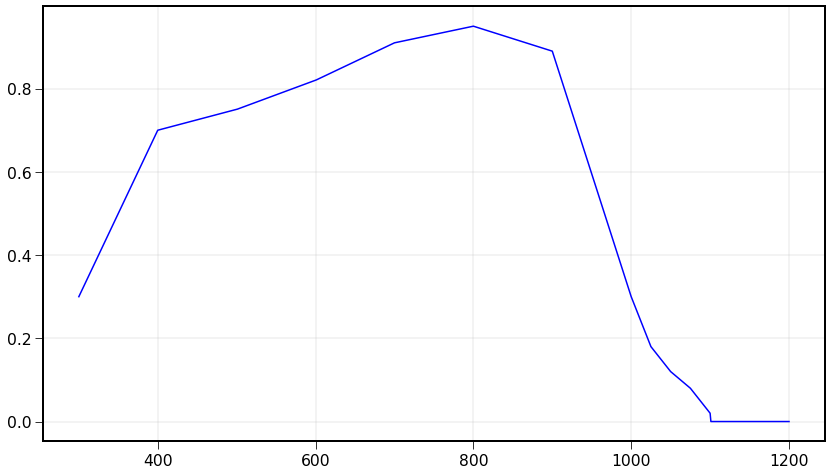

In [72]:
plt.plot(wl,ccdqe,"b-")
plt.grid()

In [73]:
bp_qe= S.ArrayBandpass(wl*10.,ccdqe, name='QE')

## Get transmission QE and Atmosphere

In [74]:
bp_qeatm=bp_atm*bp_qe

# Build the observed spectra

## Without Hologram efficiency

((atm * QE)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm * QE)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm * QE)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm * QE)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm * QE)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm * QE)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm * QE)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm * QE)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((atm * QE)) does not have a defined binset in the wavecat table. The wa

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Text(0.5, 1.0, 'Observed spectra - Flat disperser transmission')

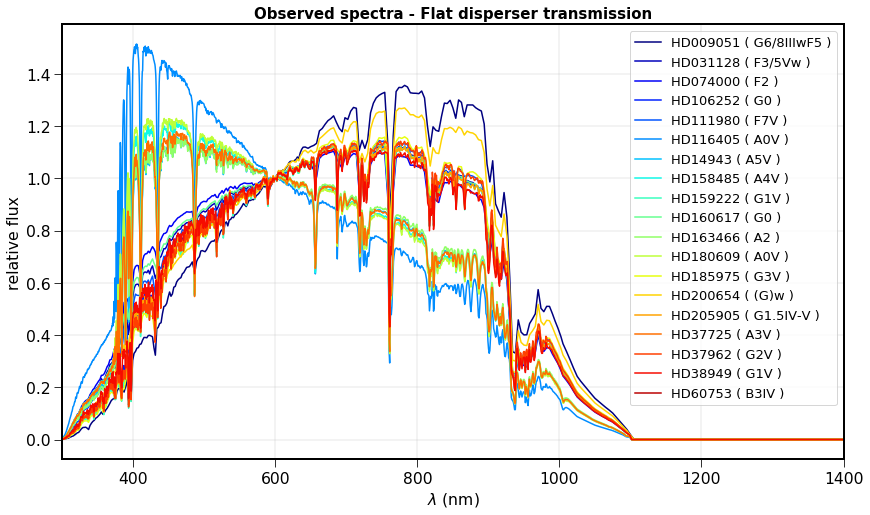

In [75]:
idx=0
all_obs=[]
for sed in all_sed:
    obs = S.Observation(sed, bp_qeatm,force='taper')
    
    wl_idx=np.argmin(np.abs(obs.binwave-6000))
    color=all_colors[idx]
    
    plt.plot(obs.binwave/10.,obs.binflux/obs.binflux[wl_idx],color=color,label=all_label[idx])
    
    all_obs.append(obs)
    idx+=1
    
plt.legend()
plt.xlim(300,1400)
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("relative flux")
plt.grid()
plt.title("Observed spectra - Flat disperser transmission",fontsize=15)

## With Theoretical Hologram Efficiency

- Here we take the theoretical hologram efficiency instead of the measured true efficiency

In [76]:
X0=1000
X=wl
Eff_holo=sp.jv(1, X0/X)**2

In [77]:
bp_holo= S.ArrayBandpass(wl*10.,Eff_holo, name='Holo')

In [78]:
bp_all=bp_qeatm*bp_holo

(((atm * QE) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((atm * QE) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((atm * QE) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((atm * QE) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((atm * QE) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((atm * QE) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((atm * QE) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((atm * QE) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Text(0.5, 1.0, 'Observed spectra - Hologram disperser transmission : $X_0$= 1000 nm')

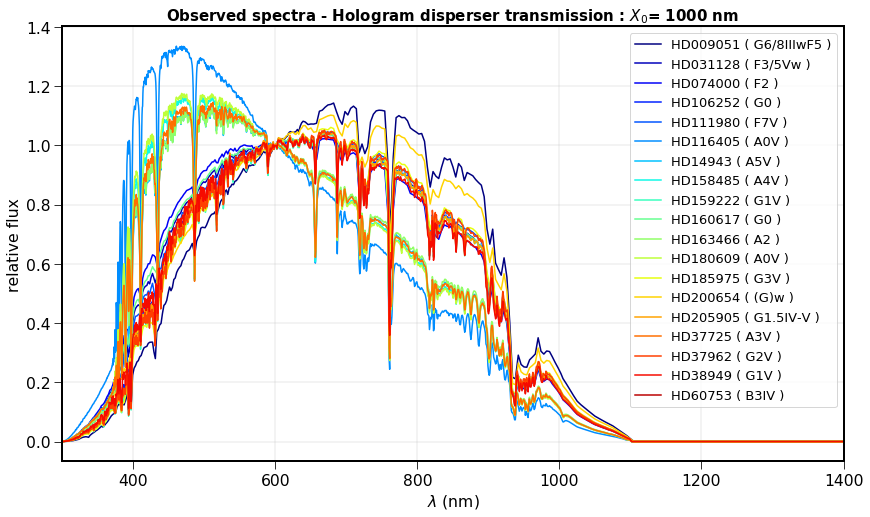

In [79]:
idx=0
all_obs=[]
for sed in all_sed:
    obs = S.Observation(sed, bp_all,force='taper')
    
    wl_idx=np.argmin(np.abs(obs.binwave-6000))
    color=all_colors[idx]
    
    plt.plot(obs.binwave/10.,obs.binflux/obs.binflux[wl_idx],color=color,label=all_label[idx])
    
    all_obs.append(obs)
    idx+=1
    
plt.legend()
plt.xlim(300,1400)
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("relative flux")
plt.grid()
title="Observed spectra - Hologram disperser transmission : $X_0$= {:d} nm".format(X0)
plt.title(title,fontsize=15)

# Single spectra but many possible theoretical hologram transmissions

In [80]:
sed_idx=0

In [81]:
the_sed=all_sed[sed_idx]
the_sed_name=label=t_vis["OBJNAME"][sed_idx]+" ( "+t_vis["SP_TYPE"][sed_idx]+" )"

In [82]:
# different hypothesis on the hologram parameter
ALL_X0=np.arange(700.,1200.,100)
NX0=len(ALL_X0)

In [83]:
cNorm = colors.Normalize(vmin=0, vmax=NX0)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NX0), alpha=1)

In [84]:
all_eff=[]
X=wl
all_label=[]
for X0 in ALL_X0: 
    Y=sp.jv(1, X0/X)**2
    all_eff.append(Y)
    label="$X_0$ = {} nm".format(X0)
    all_label.append(label)

In [85]:
all_bp_effholo=[]
for idx in np.arange(NX0):
    bp_holo= S.ArrayBandpass(wl*10.,all_eff[idx], name=all_label[idx])
    all_bp_effholo.append(bp_holo)

((((atm * QE) * Holo) * $X_0$ = 700.0 nm)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((atm * QE) * Holo) * $X_0$ = 800.0 nm)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((atm * QE) * Holo) * $X_0$ = 900.0 nm)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((atm * QE) * Holo) * $X_0$ = 1000.0 nm)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((((atm * QE) * Holo) * $X_0$ = 1100.0 nm)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


Text(0.5, 1.0, 'Observed spectra for SED HD009051 ( G6/8IIIwF5 ) - Theoretical Hologram disperser transmission ')

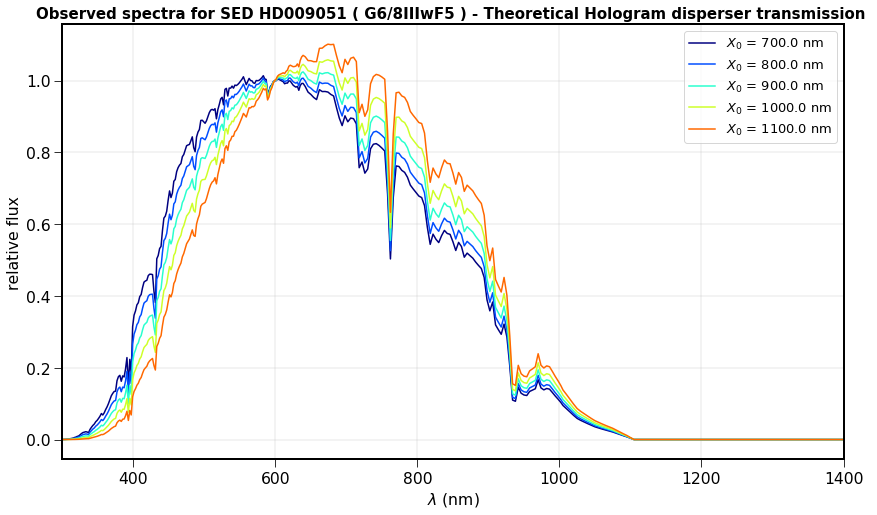

In [86]:
idx=0
all_obs=[]
for idx in np.arange(NX0):
    
    bp_all_holo=bp_all*all_bp_effholo[idx]
    obs = S.Observation(the_sed, bp_all_holo,force='taper')
    
    wl_idx=np.argmin(np.abs(obs.binwave-6000))
    color=all_colors[idx]
    
    plt.plot(obs.binwave/10.,obs.binflux/obs.binflux[wl_idx],color=color,label=all_label[idx])
    
    all_obs.append(obs)
    idx+=1
    
plt.legend()
plt.xlim(300,1400)
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("relative flux")
plt.grid()
title="Observed spectra for SED {} - Theoretical Hologram disperser transmission ".format(the_sed_name)
plt.title(title,fontsize=15)